True


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting up sentiment analysis pipeline
Sentiment analysis pipeline setup complete


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   Unnamed: 0        username  \
0           0   lisamurkowski   
1           1  sencortezmasto   
2           2     judgetedpoe   
3           3   senjackyrosen   
4           4  repmarkmeadows   

                                                text       party  \
0  launches pacific spaceport complex significant...  republican   
1  going restore economy finally defeat virus her...    democrat   
2  join reppeteolson monday april rd forum addres...  republican   
3  house passed background check expansion act bi...    democrat   
4  higher calling serving veterans laid lives lin...  republican   

                                          clean_text  \
0  launches pacific spaceport complex significant...   
1  going restore economy finally defeat virus her...   
2  join reppeteolson monday april rd forum addres...   
3  house passed background check expansion act bi...   
4  higher calling serving veterans laid lives lin...   

                                           sentiment se

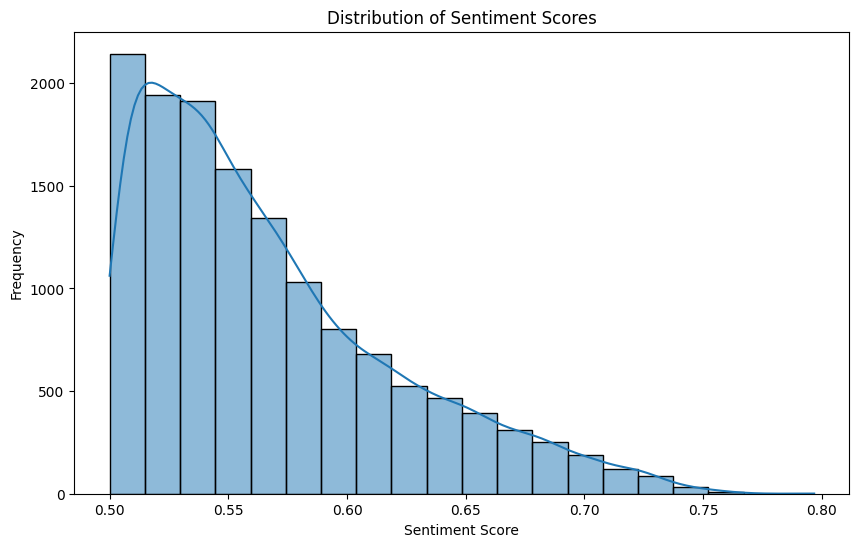

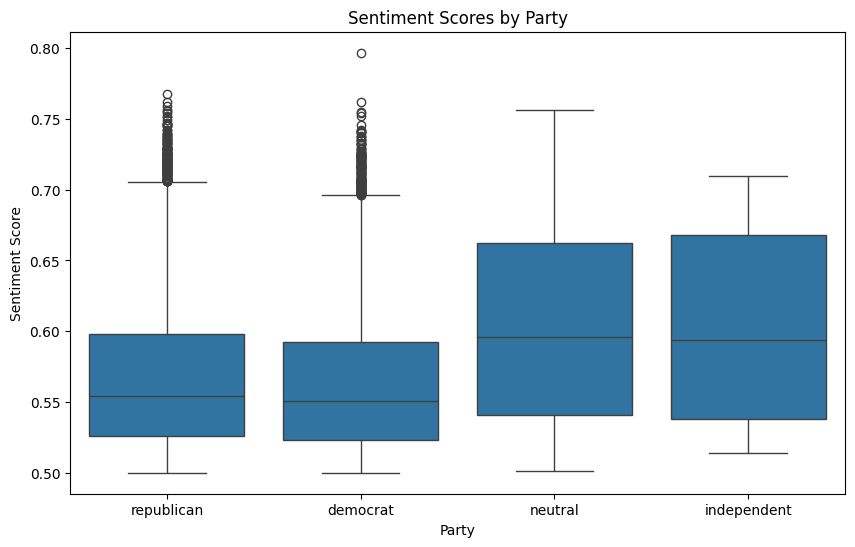

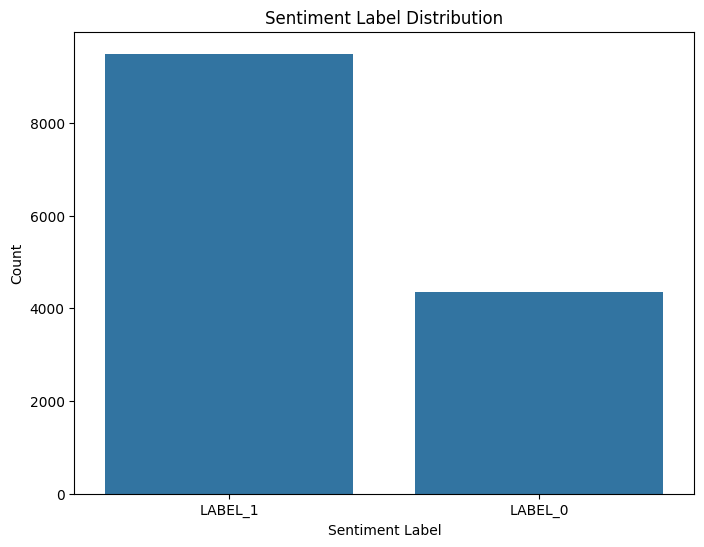

sentiment_label   LABEL_0   LABEL_1
party                              
democrat         0.325062  0.674938
independent      0.111111  0.888889
neutral          0.161049  0.838951
republican       0.309527  0.690473


In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Check GPU availability
print(torch.cuda.is_available())

# Load the CSV file
df = pd.read_csv('poli_texts_processed.csv')

# Drop rows with missing text and preprocess the text
df.dropna(subset=['text'], inplace=True)

# Preprocess the text (lowercase, remove special characters, etc.)
df['clean_text'] = df['text'].str.replace(r'http\S+|www\S+', '', regex=True)  # remove URLs
df['clean_text'] = df['clean_text'].str.replace(r'\W', ' ', regex=True)  # remove non-alphanumeric chars
df['clean_text'] = df['clean_text'].str.lower()  # convert to lowercase

# Load pre-trained BERT tokenizer and model for sentiment analysis
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create sentiment analysis pipeline
print("Setting up sentiment analysis pipeline")
sentiment_analyzer = pipeline(
    'sentiment-analysis',
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    padding=True,
    truncation=True,
    max_length=512  # Ensure the sequences do not exceed the max length of BERT
)

print("Sentiment analysis pipeline setup complete")

# Batch process the texts for sentiment analysis
batch_size = 32
results = []

# Process the text in batches
for i in range(0, len(df), batch_size):
    batch_texts = df['clean_text'].iloc[i:i+batch_size].tolist()
    batch_results = sentiment_analyzer(batch_texts)
    results.extend(batch_results)

# Add sentiment results to DataFrame
df['sentiment'] = results
df['sentiment_label'] = df['sentiment'].apply(lambda x: x['label'])
df['sentiment_score'] = df['sentiment'].apply(lambda x: x['score'])

# Display the first few rows of the DataFrame to verify
print(df.head())

# Visualizations

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], kde=True, bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Boxplot to compare sentiment scores by party
plt.figure(figsize=(10, 6))
sns.boxplot(x='party', y='sentiment_score', data=df)
plt.title('Sentiment Scores by Party')
plt.xlabel('Party')
plt.ylabel('Sentiment Score')
plt.show()

# Countplot to show sentiment label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=df)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

# Create a crosstab to show sentiment by party
sentiment_by_party = pd.crosstab(df['party'], df['sentiment_label'], normalize='index')
print(sentiment_by_party)


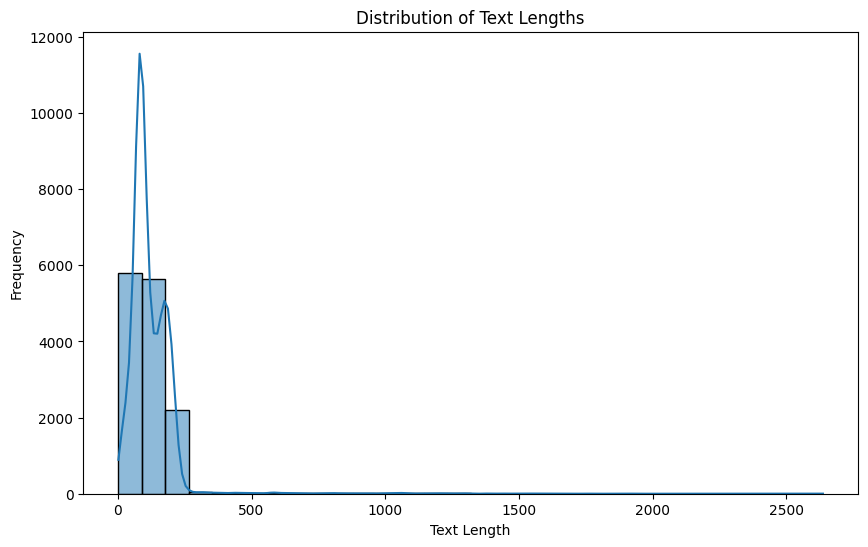

In [ ]:
# Create a new column for text length
df['text_length'] = df['clean_text'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True, bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

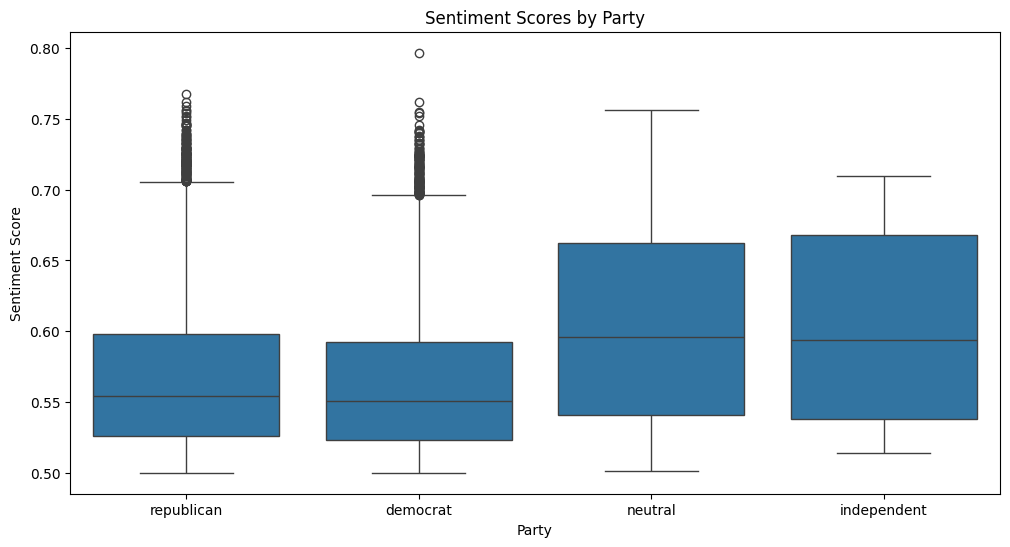

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='party', y='sentiment_score', data=df)
plt.title('Sentiment Scores by Party')
plt.xlabel('Party')
plt.ylabel('Sentiment Score')
plt.show()

                 text_length  sentiment_score
text_length         1.000000         0.038305
sentiment_score     0.038305         1.000000


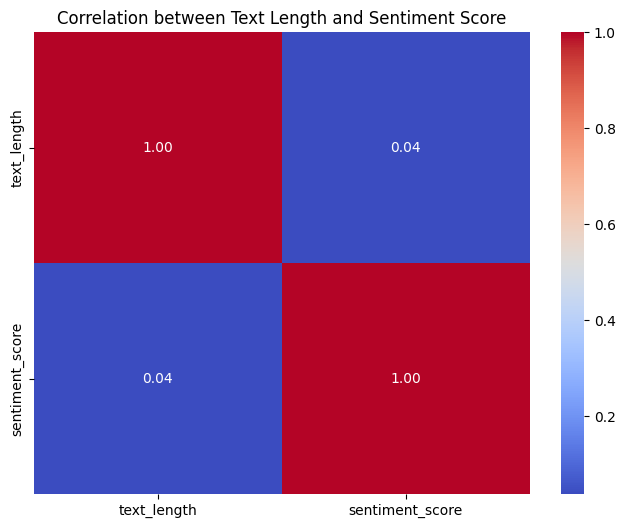

In [ ]:
# Calculate the correlation between text length and sentiment score
correlation = df[['text_length', 'sentiment_score']].corr()

# Display the correlation matrix
print(correlation)

# Plot the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Text Length and Sentiment Score')
plt.show()


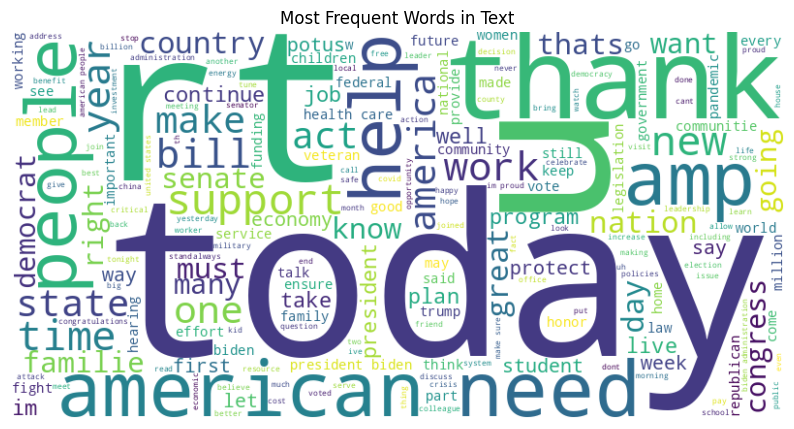

In [ ]:
from wordcloud import WordCloud

# Combine all the cleaned text into one string
text_data = ' '.join(df['clean_text'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Text')
plt.show()

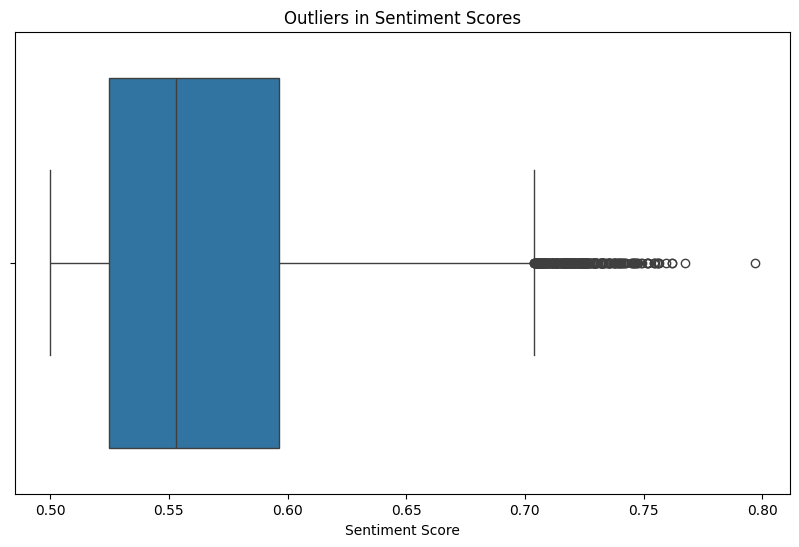

In [ ]:
# Plotting sentiment scores with boxplot to detect outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sentiment_score'])
plt.title('Outliers in Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.show()